# Social networks and domains

This notebook explores the the structural role of participants in a network. Network data from Leviticus 17-26 is used as a case. The basis for this inquiry is the fact that texts are not one-dimensional. They are structured and can contain several layers, or domains. The participants of a text are therefore not necessarily positioned on the same level, but belong to specific domains. They may even belong to a domain which is embedded in another domain. In that sense, a domain (and its participants!) is 'controlled' or 'occasioned' by another domain. This notebook, therefore, will explore the participants of Leviticus 17-26 and the domains which they occupy. Moreover, a network model will be created in which the control of one domain over another is conceptualized as edges between participants.

**Content**
1. Preparation
2. Participants and domains
3. A network of control
4. SNA-measures of the 'control network'

In [2]:
import collections
import pandas as pd
import networkx as nx
import forceatlas2
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tf.app import use

In [3]:
A = use('bhsa', hoist=globals())

## 1. Preparations

The network dataset of participants is imported. Additional information is yielded from the ETCBC database, including domain (narrative (N) or quotation (Q)), texttype (i.e. domain plus embeddedness). 

In [4]:
data = pd.read_excel('Lev17-26.edges.Static.xlsx')
data.head()

,Source,Source_agency,Target,Target_agency,Label,Weight,Clause
0,Aaron's_sons,5,YHWH,0,swing,25,440323
1,YHWH,5,Moses,-1,speak,36,440335
2,Israelites,5,YHWH,-1,approach,36,440341
3,YHWH,5,Moses,-1,speak,36,440342
4,Israelites,5,YHWH,-1,approach,36,440347


In [5]:
clause_atom = [L.d(cl, 'clause_atom') for cl in list(data.Clause)]
domain = [F.domain.v(cl) for cl in list(data.Clause)]
texttype = [F.txt.v(cl) for cl in list(data.Clause)]
level = [len(F.txt.v(cl)) for cl in list(data.Clause)]

data.insert(7, 'clause_atom', clause_atom)
data.insert(8, 'domain', domain)
data.insert(9, 'texttype', texttype)
data.insert(10, 'level', level)

Chapter 26 naturally follows chapter 25, as the deployment of definite pronouns in 26:1 indicates. In other words, chapter 26 continues the speech of the preceding chapter. The texttype, however, is labeled relative to chapter, which means that the chapter 26 begins at level 1, rather than level 3 as in the end of chapter 25. This must be changed for Lev 26:1-45 (Thus, 26:46 is not part of the speech):

In [6]:
first_ca = L.d(T.nodeFromSection(('Leviticus',26,1)), 'clause')[0]
last_ca = L.d(T.nodeFromSection(('Leviticus',26,45)), 'clause')[-1]

for n, row in data.iterrows():
    if row.Clause in range(first_ca, last_ca+1):
        data.at[n, "texttype"] = f'NQ{row.texttype}' #NQ added prefixed to texttype
        data.at[n, "level"] = row.level+2 #level is increased by 2.

In [7]:
data.head()

,Source,Source_agency,Target,Target_agency,Label,Weight,Clause,clause_atom,domain,texttype,level
0,Aaron's_sons,5,YHWH,0,swing,25,440323,"(528861,)",Q,NQQ,3
1,YHWH,5,Moses,-1,speak,36,440335,"(528874,)",N,N,1
2,Israelites,5,YHWH,-1,approach,36,440341,"(528880,)",Q,NQQ,3
3,YHWH,5,Moses,-1,speak,36,440342,"(528881,)",N,N,1
4,Israelites,5,YHWH,-1,approach,36,440347,"(528886,)",Q,NQ,2


## 2. Participants and domains

The participants and their respective embeddedness ('texttype' and 'level' in the dataset) will now be cross-tabulated to observe their distribution. Only Actors will be considered (that is, "Source" in the dataset), because only Actors can reasonably be said to 'control' a sentence or a domain.

In [10]:
df = pd.crosstab(index=data.Source, columns=data.level, margins=True).sort_values(by='All', ascending=False)
df.head()

level,1,2,3,4,5,All
Source,,,,,,
All,32,92,342,10,1,477
YHWH,20,15,75,4,1,115
Israelites,2,8,70,4,0,84
2msg,0,1,68,0,0,69
an_Israelite,0,0,42,0,0,42


In [11]:
props = df.div(df['All'], axis='index')
props.head()

level,1,2,3,4,5,All
Source,,,,,,
All,0.067086,0.192872,0.716981,0.020964,0.002096,1.0
YHWH,0.173913,0.130435,0.652174,0.034783,0.008696,1.0
Israelites,0.023810,0.095238,0.833333,0.047619,0.000000,1.0
2msg,0.000000,0.014493,0.985507,0.000000,0.000000,1.0
an_Israelite,0.000000,0.000000,1.000000,0.000000,0.000000,1.0


In [13]:
#Transforming the table
stacked = df[:15].stack().reset_index().rename(columns={0:'value'})
stacked = stacked[(stacked.Source != "All") & (stacked.level != 'All')]
stacked

,Source,level,value
6,YHWH,1,20
7,YHWH,2,15
8,YHWH,3,75
9,YHWH,4,4
10,YHWH,5,1
...,...,...,...
84,group_of_people,1,0
85,group_of_people,2,0
86,group_of_people,3,3
87,group_of_people,4,0


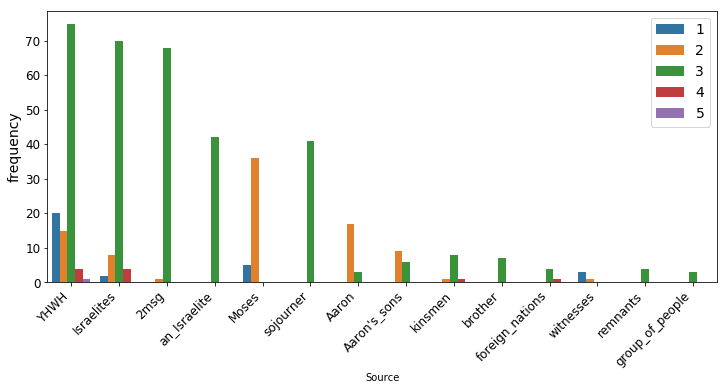

In [14]:
fig, ax = plt.subplots(figsize=(12,5))

sns.barplot(x="Source", y="value", hue="level", data=stacked)
plt.xticks(rotation='45', size=12, ha='right')
plt.ylabel('frequency', size=14)
plt.yticks(size=12)
plt.legend(fontsize=14)

plt.show()

## 3. A network of control

In order to create a 'network of control', it must be calculated which clauses are indeed in a conditional relationship. It is not enough to use the 'texttype' of the dataset because the embeddedness of a clause does not tell to which clause it is embedded.

Fortunately, the ETCBC database contains an edge-feature that conceptualizes the conditional relationship between clauses. This edge-feature is called 'mother'. The procedure here is two-step because we are not only interested in which clause is the 'mother' of which clause, but we essentially want a recursive list of (grand)daughter clauses. We therefore start by creating a dataframe with the mother clause of each clause. Secondly, we track the links between mothers and daughters to create a list of clauses being daughters (or grand-grand... etc.)daughters of any clause.

#### 3a Get the mother clause

In [22]:
def get_mother(clause_atom):

    this_texttype = F.txt.v(L.u(clause_atom, 'clause')[0])
    mother = next((m for m in E.mother.f(clause_atom)), 0)
    
    if mother:
        return mother
    
    elif 'Q' in this_texttype and not mother: #If no mother to quotation, allow to skip one clause-atom (in effect, 
                                              #to preceeding chapter)
        return get_mother(clause_atom-1)
    
    else:
        return None

#get_mother(529083)

Creating a dataframe with clause atoms and their immediate mother:

In [23]:
first_ca = L.d(T.nodeFromSection(('Leviticus',17,1)), 'clause_atom')[0]
last_ca = L.d(T.nodeFromSection(('Leviticus',26,46)), 'clause_atom')[-1]

mother_dict = {}

for ca in range(first_ca, last_ca+1):
    mother_dict[ca] = get_mother(ca)
    
mother_df = pd.DataFrame([mother_dict]).T
mother_df.columns = ['daughter']
mother_df.head()

,daughter
528163,None
528164,528163
528165,528164
528166,528165
528167,528166


#### 3b Get dauther clauses

The procedure from above is now reversed so that the mother_dataframe is traversed to find all daughters that can be tracked back to a mother clause by recursively identifying the mother.

In [24]:
def get_daughters(clause_atom, df=mother_df, daughters=set()):
  
    daughter_clauses = []
    
    for cl in clause_atom:
        if cl in list(df.daughter):
            daughter_clauses += list(df[df.daughter == cl].index)
    
    if len(daughter_clauses) > 0:
        daughters.update(daughter_clauses)
        return get_daughters(daughter_clauses, daughters=daughters)
    else: 
        return daughters
    
#get_daughters([528165])

In [25]:
ownership_list = []

for n in list(mother_df.index):
    ownership_list.append(get_daughters([n], daughters=set()))
    
mother_df.insert(1, 'ownership_len', [len(n) for n in ownership_list])
mother_df.insert(2, 'ownership', ownership_list)

In [26]:
mother_df

,daughter,ownership_len,ownership
528163,None,73,"{528164, 528165, 528166, 528167, 528168, 52816..."
528164,528163,72,"{528165, 528166, 528167, 528168, 528169, 52817..."
528165,528164,71,"{528166, 528167, 528168, 528169, 528170, 52817..."
528166,528165,70,"{528167, 528168, 528169, 528170, 528171, 52817..."
528167,528166,19,"{528168, 528169, 528170, 528171, 528172, 52817..."
...,...,...,...
529378,529377,1,{529379}
529379,529378,0,{}
529380,529376,0,{}
529381,None,1,{529382}


Not all ownership clauses are actually part of the SNA dataset. The dataframe needs therefore be filtered with respect to the SNA-data.

In [27]:
ownership_list1 = []

sna_clause_atoms = [a for cl in list(data.clause_atom) for a in cl] #all clause-atoms in the dataset in a plain list.

actual_ownership = collections.defaultdict(set)
for n, row in data.iterrows():
    
    for cl in row.clause_atom:
        possible_ownership = mother_df[mother_df.index == cl].ownership.item()
        if possible_ownership:
            for d in possible_ownership:
                if d in sna_clause_atoms:
                    actual_ownership[row.Clause].add(L.u(d, 'clause')[0])
                    
#actual_ownership

In [29]:
ownership = []

for n, row in data.iterrows():
    if row.Clause in actual_ownership:
        ownership.append(actual_ownership[row.Clause])
    else:
        ownership.append(set())
        
data.insert(11, 'ownership', ownership)
data.insert(12, 'ownership_len', [len(n) for n in ownership])

In [30]:
data

,Source,Source_agency,Target,Target_agency,Label,Weight,Clause,clause_atom,domain,texttype,level,ownership,ownership_len
0,Aaron's_sons,5,YHWH,0,swing,25,440323,"(528861,)",Q,NQQ,3,{},0
1,YHWH,5,Moses,-1,speak,36,440335,"(528874,)",N,N,1,"{440384, 440353, 440356, 440391, 440392, 44036...",16
2,Israelites,5,YHWH,-1,approach,36,440341,"(528880,)",Q,NQQ,3,{},0
3,YHWH,5,Moses,-1,speak,36,440342,"(528881,)",N,N,1,"{440384, 440353, 440356, 440391, 440392, 44036...",13
4,Israelites,5,YHWH,-1,approach,36,440347,"(528886,)",Q,NQ,2,{},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,brother's_uncle,5,brother,-1,redeem,36,440637,"(529189,)",Q,NQQ,3,{440638},1
473,man,0,handmaid,-2,spend autumn,4,439885,"(528407,)",Q,NQQ,3,{},0
474,husband,5,widowed/expelled/defiled_woman,-2,drive out,49,440088,"(528616,)",Q,NQ,2,{},0
475,witnesses,5,blasphemer,-2,settle,49,440424,"(528966,)",N,N,1,{},0


Now we can wiew the ownership of a clause. The function below shows a mother clause (colored 'salmon') and the rest of the clauses with the span of the ownership. Clauses actually 'owned' or 'controlled' by the mother are colored 'gold'.

In [31]:
def show(clause, df=data):
    
    A.pretty(clause, highlights={clause:'salmon'})
    ownership = df[df.Clause == clause].ownership
    
    for o in ownership:
        if o:
            print(f'Number of interactions controlled: {len(o)}')
            for cl in range(clause+1, max(o)+1):
                A.pretty(cl, highlights={cl: 'gold' for cl in o})
            break
        
    else:
        return "No ownership"

show(440417)

Number of interactions controlled: 21


We can also calculate the 'volume' of ownership by combining all ownership clauses for a single participant (duplicate clauses are ignored):

In [33]:
def ownershipVolume(actor, data=data):
    
    actor_df = data[data.Source == actor]
    
    ownership = set()
    for n in list(actor_df.ownership):
        ownership.update(n)
        
    return ownership

len(ownershipVolume('Moses'))

304

In [34]:
len(ownershipVolume('2ms'))

0

#### 3c. A network of control

Two participants are connected if the domain owned by one participant include the other. The number of owned clauses is the weight of the edges.

In [37]:
def controlNetwork(data=data, network_type=nx.MultiDiGraph()):

    G = network_type

    for actor in set(data.Source):

        for cl in ownershipVolume(actor):

            for n in data[data.Clause == cl].Source:
                G.add_edge(actor, n)

            for n in data[data.Clause == cl].Target:
                G.add_edge(actor, n)
                
    return G

In [38]:
G = controlNetwork(network_type = nx.MultiGraph())

pos = { i : (random.random(), random.random()) for i in G.nodes()}
l = forceatlas2.forceatlas2_networkx_layout(G, pos, niter=2000, gravity=30, scalingRatio=5.0)

In [39]:
len(G.edges())

2726

C:\Users\Ejer\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


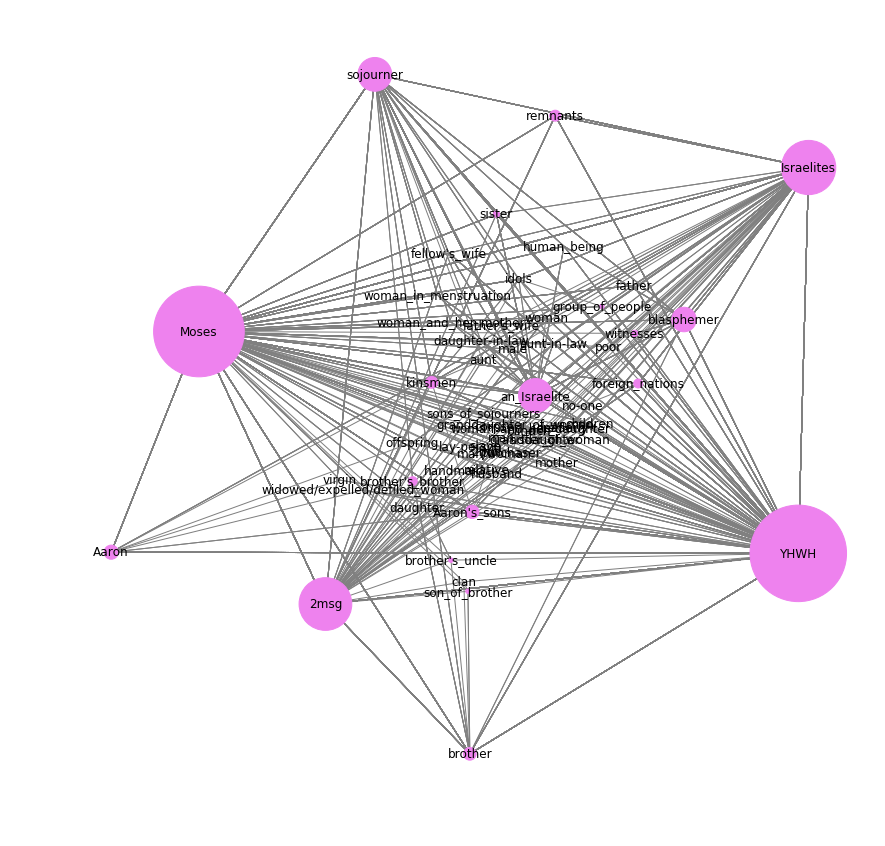

In [40]:
plt.figure(figsize = (15,15))

nx.draw_networkx(G, l, node_color='violet',
                 node_size=[n[1]*10 for n in controlNetwork(network_type=nx.MultiDiGraph()).out_degree()], 
                 edge_color='grey')

plt.axis('off')
plt.margins(x=0.1, y=0.1)

#plt.savefig('screenshots/Leviticus_SNA.png', dpi=500)
plt.show()

## 4. SNA meassures of the control network

In [62]:
nx.density(G)

1.5932203389830508

In [63]:
degree = G.degree()
sum_degree = sum(dict(degree).values())
print(f'Average degree: {sum_degree/len(G.nodes())}')

Average degree: 92.40677966101696


#### Reciprocity

#### Centrality measures

In [64]:
G1 = controlNetwork(network_type=nx.MultiDiGraph())

In [65]:
indegree = nx.in_degree_centrality(G1)
outdegree = nx.out_degree_centrality(G1)
betweenness = nx.betweenness_centrality(G1)

In [66]:
centrality = pd.DataFrame([indegree, outdegree, betweenness]).T
centrality.columns = ['indegree','outdegree','betweeness']
centrality.head()

,indegree,outdegree,betweeness
2msg,4.672414,4.793103,0.024975
deaf,0.068966,0.000000,0.000000
blind,0.068966,0.000000,0.000000
YHWH,8.603448,16.068966,0.118644
rich,0.068966,0.000000,0.000000


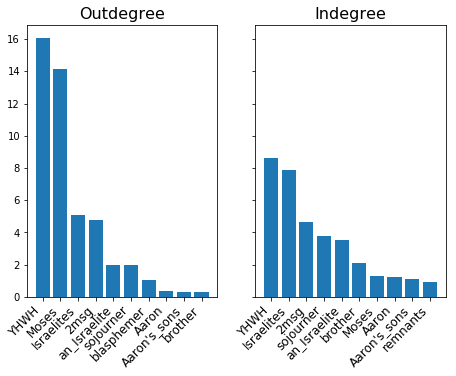

In [67]:
def top(measure, df=centrality):
    return df.sort_values(by=measure, ascending=False)[measure][:10]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5,5), sharey=True)

ax1.bar(top('outdegree').index, top('outdegree'))
ax1.set_title("Outdegree", size=16)
ax2.bar(top('indegree').index, top('indegree'))
ax2.set_title("Indegree", size=16)
#ax3.bar(top('betweeness').index, top('betweeness'))
#ax3.set_title("Betweenness", size=16)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right', size=12)

plt.show()

#### Removal test

In [75]:
def removalTest(ego):
    
    density_dict = {}
    for n in ego.nodes():
        remove = [l for l in ego.nodes() if l!=n]
        new_graph = ego.subgraph(remove)
        density_dict[n] = nx.density(new_graph)

    removal_df = pd.DataFrame([density_dict]).T
    removal_df.columns=['density']
    return removal_df

#removalTest(G)

Original density of network: 1.5932203389830508


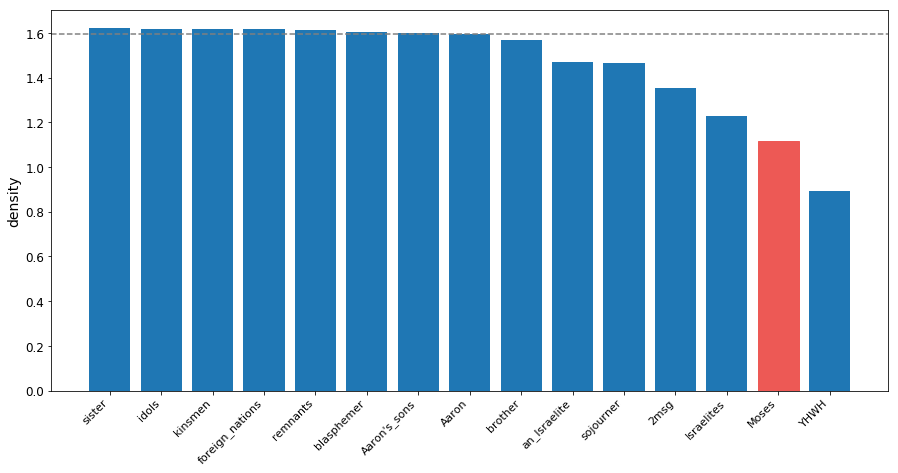

In [76]:
def plotDF(graph, column, size=(15,7), actor=str, typ='ego', plot_graph=False, line=True):
    
    if typ == 'ego':
        ego = nx.ego_graph(graph, actor, undirected=True)
        df = removalTest(ego)
        df = df.sort_values(by=column, ascending=False)
        ego_index = df.index.get_loc(actor)
        density = nx.density(ego)
        print(f'Original density of egonetwork: {density}')
 
    elif typ == 'graph':
        df = removalTest(graph)
        df = df.sort_values(by=column, ascending=False).tail(15)
        density = nx.density(graph)
        print(f'Original density of network: {density}')
    
    fig, ax = plt.subplots(figsize=size)
    plot = plt.bar(df.index, df[column])
    if actor:
        actor_index = df.index.get_loc(actor)
        plot[actor_index].set_color('#ED5955')
    plt.ylabel("density", size=14)
    plt.xticks(size=11, rotation=45, ha='right')
    plt.yticks(size=12)
    
    if line:
        plt.axhline(y=density, linestyle='dashed', color='grey')
    
    # draw graph in inset
    if plot_graph:
        plt.axes([0.4, 0.4, 0.5, 0.5])
        nodes = list(df.index)

        subgraph = graph.subgraph(nodes)
        pos = nx.spring_layout(subgraph)
        nx.draw(
            subgraph,
            pos=pos,
            with_labels=True,
            edge_color='grey',
            node_color='lightblue',
            font_size=14
            )
        nx.draw_networkx_nodes(subgraph, pos=pos, nodelist=[ego], node_color='salmon')

        plt.axis('off')

plotDF(G, actor="Moses", column='density', typ='graph', line=True)

How many levels constitute the network?

In [77]:
data = data.sort_values(by='Clause')
data.head()

,Source,Source_label,Source_agency,Target,Target_label,Target_agency,Label,Weight,clause_atom,domain,texttype,level,ownership,ownership_len,discourse_level,Type,Clause
86,43,YHWH,5,39,Moses,-1,speak,36,"(528163,)",N,N,1,"{439680, 439652, 439653, 439684, 439686, 43968...",14,0,Directed,439650
226,39,Moses,5,55,Aaron,-1,speak,36,"(528165,)",Q,NQ,2,"{439680, 439684, 439653, 439686, 439689, 43969...",13,2,Directed,439652
227,39,Moses,5,53,Israelites,-1,speak,36,"(528165,)",Q,NQ,2,"{439680, 439684, 439653, 439686, 439689, 43969...",13,2,Directed,439652
228,39,Moses,5,49,Aaron's_sons,-1,speak,36,"(528165,)",Q,NQ,2,"{439680, 439684, 439653, 439686, 439689, 43969...",13,2,Directed,439652
230,39,Moses,5,53,Israelites,-1,say,36,"(528166,)",Q,NQ,2,"{439680, 439684, 439686, 439689, 439693, 43970...",12,3,Directed,439653


In [78]:
mothers = set([n for s in list(data.ownership) for n in s])

def get_level(clause_atom, l, df=data):
    
    if get_mother(clause_atom):
        mother = get_mother(clause_atom)
        l+=1
        return get_level(mother, l)
    else:
        return l
    
    
get_level(528165, l=0)

2

In [79]:
levels = []

for cl in list(data.clause_atom):
    levels.append(get_level(cl[0], l=0))
    
data.insert(14, 'discourse_level', levels)

ValueError: cannot insert discourse_level, already exists

In [ ]:
set(data.discourse_level)

Drawing top level (level 0):

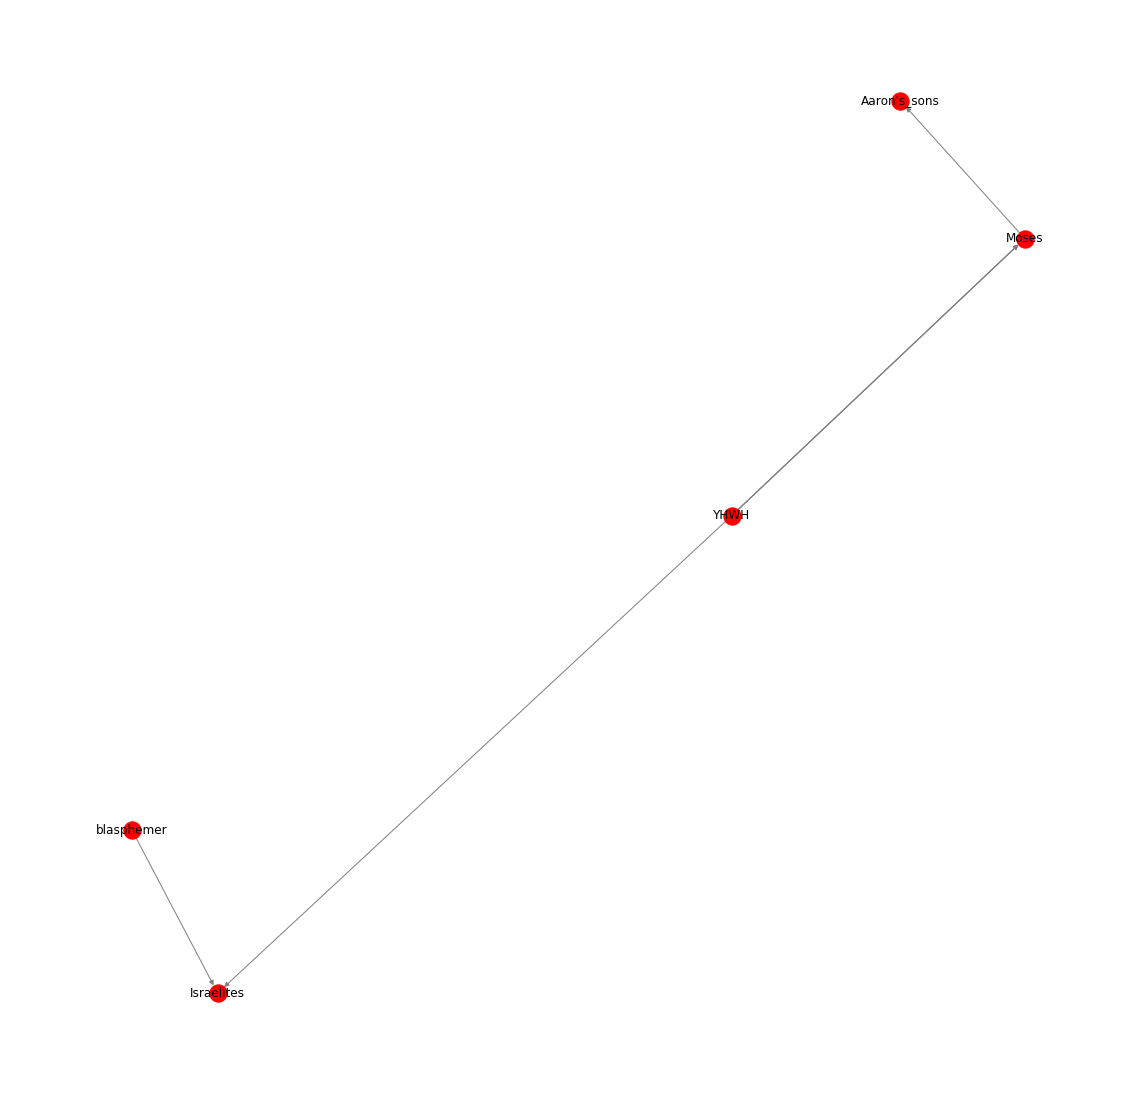

In [74]:
def draw_level(level, df=data):
    

    G = nx.MultiDiGraph()

    for n, row in data.iterrows():
        if row.discourse_level == level:
            G.add_edge(row.Source_label, row.Target_label)
            
    plt.figure(figsize = (15,15))

    nx.draw(
        G,
        pos=nx.spring_layout(G),
        with_labels=True,
        edge_color='grey'
        )

    plt.show()
    
draw_level(1)